In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

### Downsampling

In [6]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [7]:
df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

### Create downsampled trial dataframes

In [8]:
df_trials = []
num_trials = 10
for i in range(0,num_trials):
    # Down
    df_downsampled = w.downsample(X, y, df[df["Set"]=="test"])
    df_trials.append(df_downsampled)

In [9]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", "Time",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

# Run trials

In [10]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = w.one_vs_all_classify(trial, features_list, y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports/Plots

In [38]:
df_alloutput = w.store_trial_results(trial_results)
df_alloutput.to_csv('Results/wifi-alltrials.csv', mode='w')

In [39]:
df_performance_device = w.report_metrics_across('Device', df_alloutput)
display(df_performance_device)
df_performance_device.to_csv('Results/wifi-devtype-performance.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision
plug,0.620316,0.207838,0.077189,0.474153,0.226910,0.084272,0.366455,0.217324,0.080712,0.525847,0.226910,0.084272,0.209697,0.233360,0.086668
bulb,0.953626,0.060116,0.022326,0.948012,0.075013,0.027859,0.046235,0.061475,0.022831,0.051988,0.075013,0.027859,0.559029,0.339969,0.126261
camera,0.265289,0.129771,0.048196,0.208896,0.152448,0.056618,0.264955,0.182350,0.067723,0.791104,0.152448,0.056618,0.854379,0.092322,0.034288


In [40]:
df_performance_classifier = w.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)
df_performance_classifier.to_csv('Results/wifi-devtype-classifier.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision
KNN,0.655286,0.216514,0.080411,0.555577,0.208085,0.077281,0.263665,0.156754,0.058217,0.444423,0.208085,0.077281,0.429183,0.359149,0.133385
RF,0.647646,0.361540,0.134272,0.577329,0.372091,0.138191,0.124866,0.162032,0.060177,0.422671,0.372091,0.138191,0.683128,0.305565,0.113484
LDA,0.536299,0.349340,0.129742,0.498155,0.430360,0.159832,0.289114,0.269579,0.100119,0.501845,0.430360,0.159832,0.510794,0.370003,0.137416


In [41]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### AUC

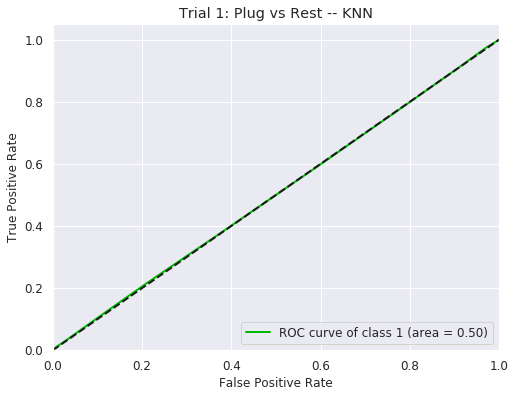

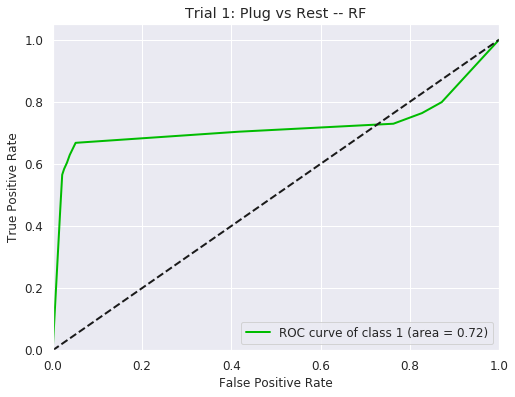

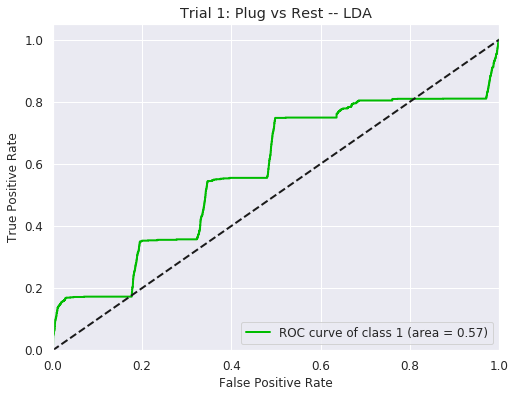

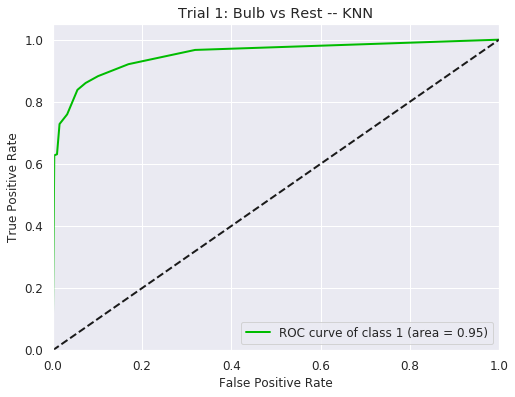

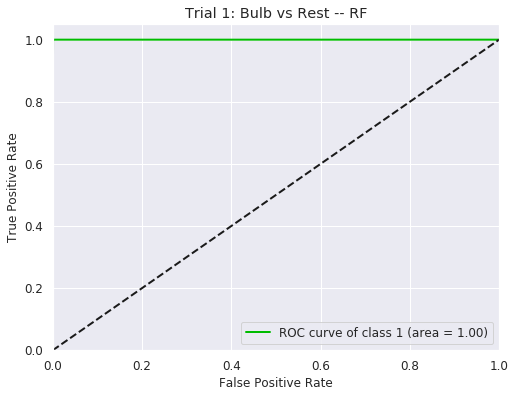

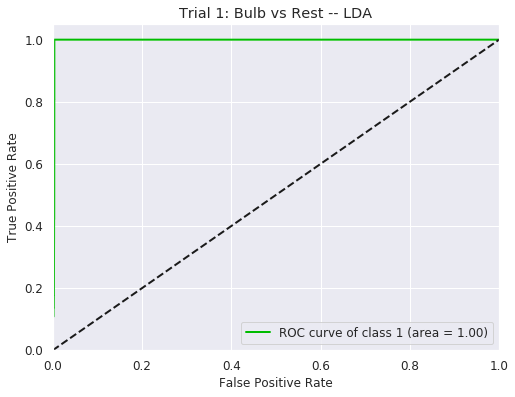

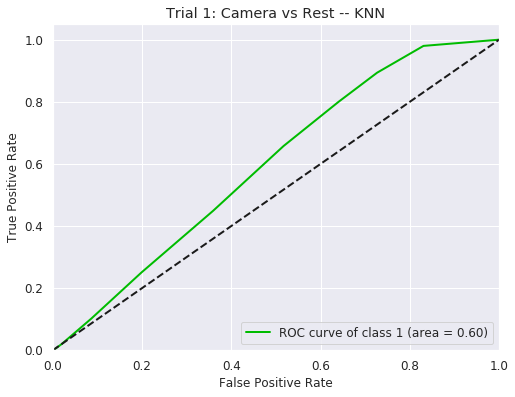

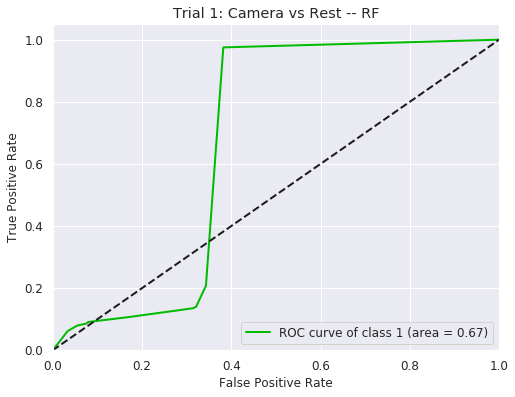

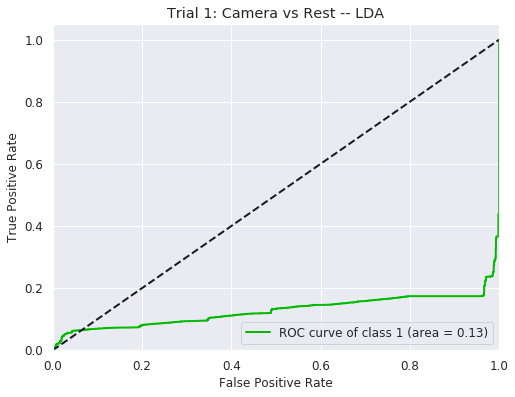

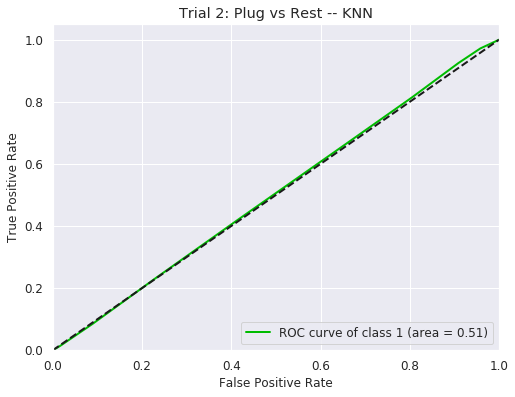

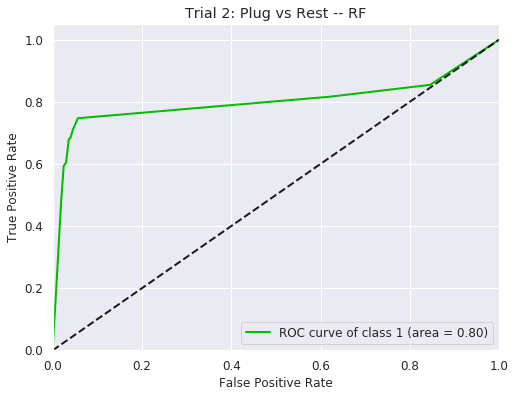

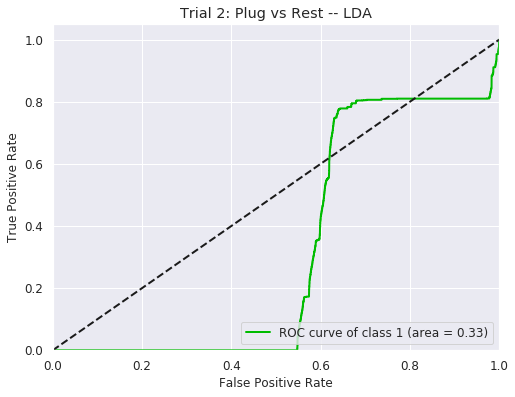

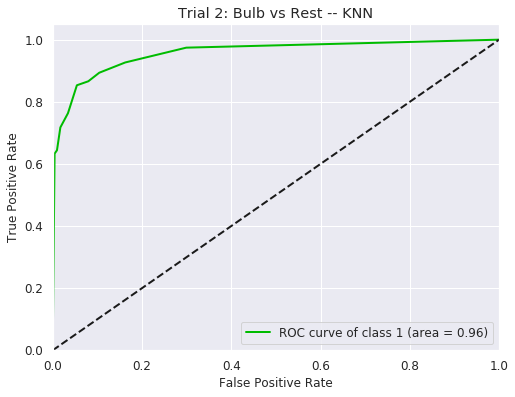

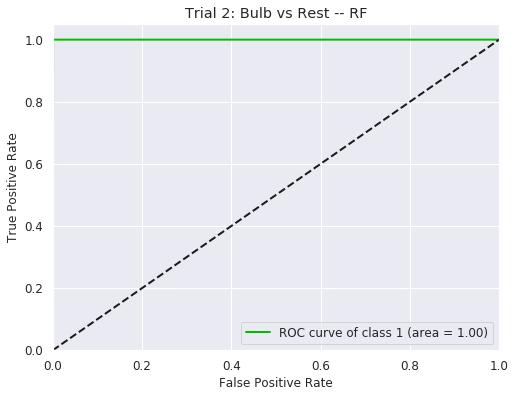

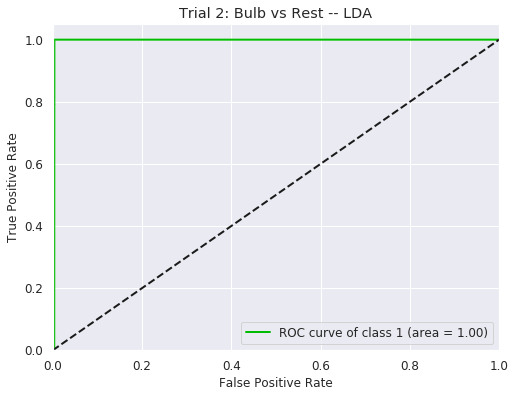

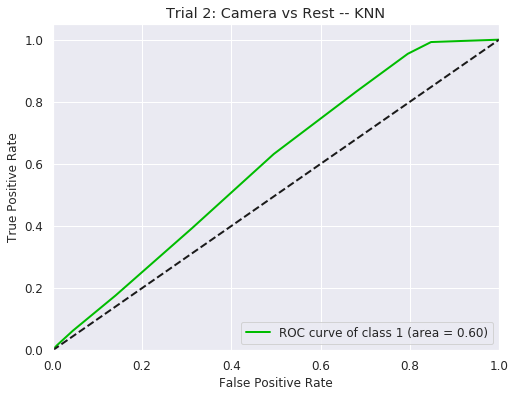

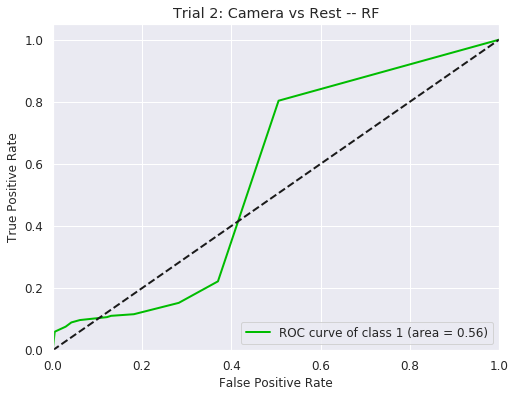

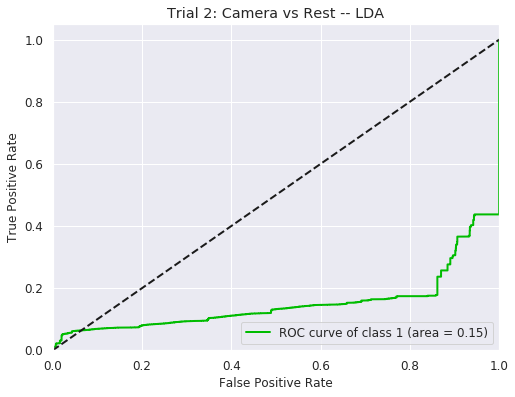

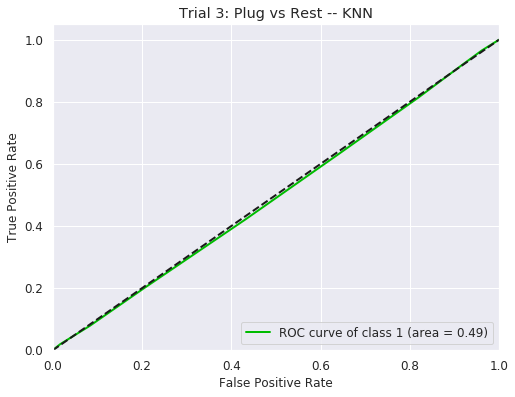

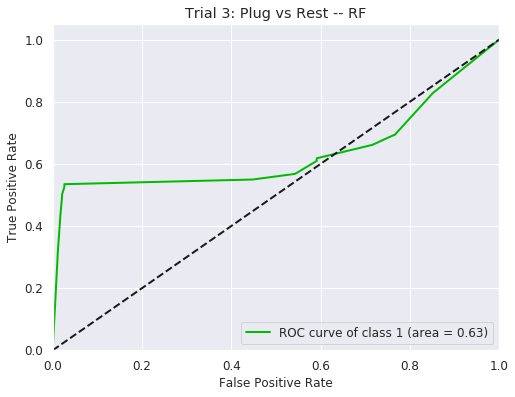

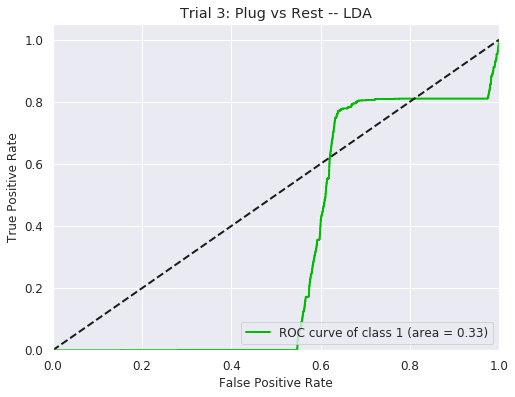

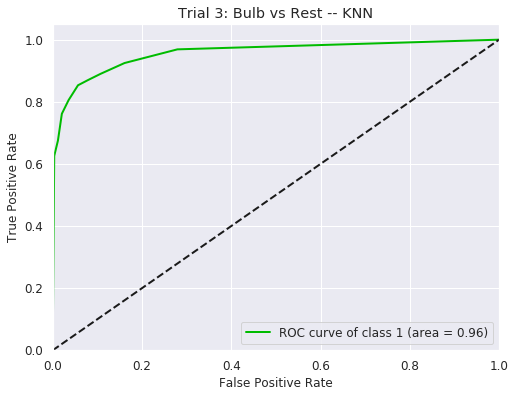

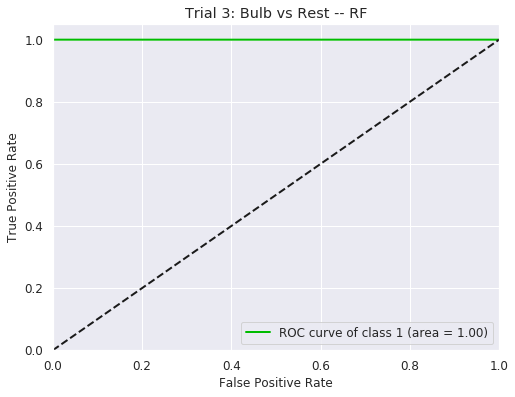

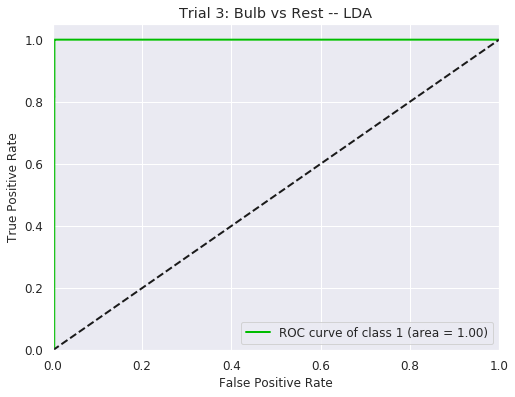

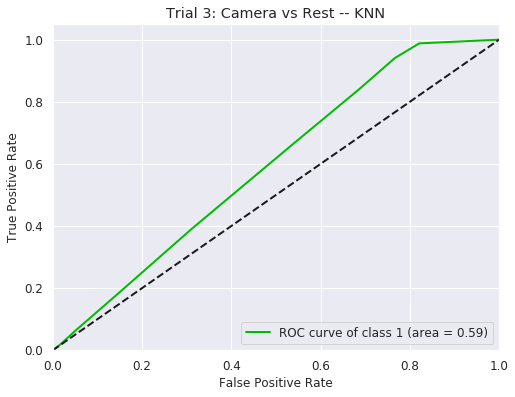

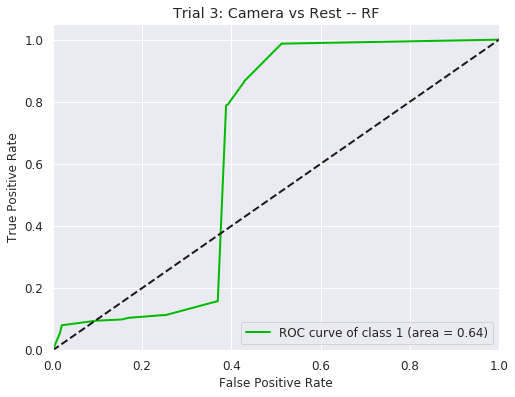

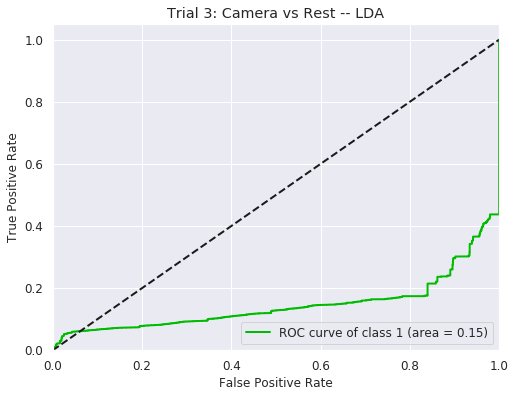

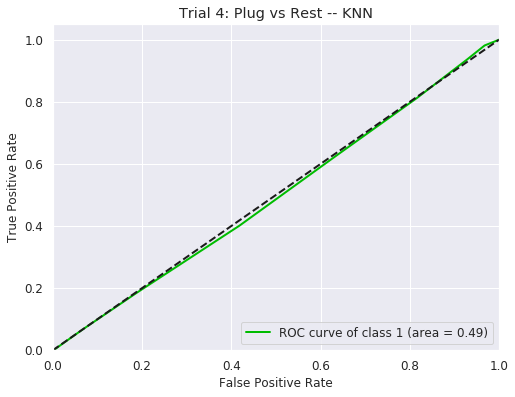

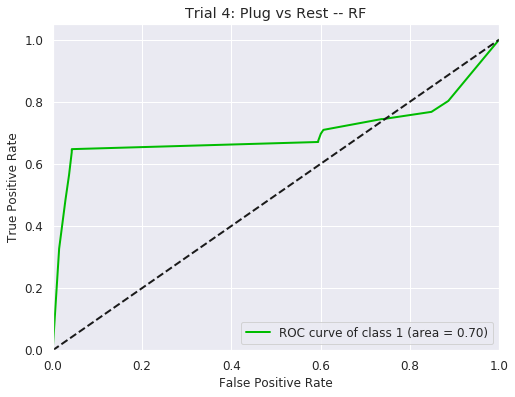

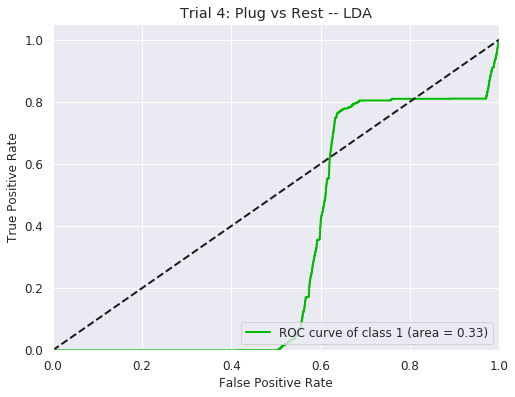

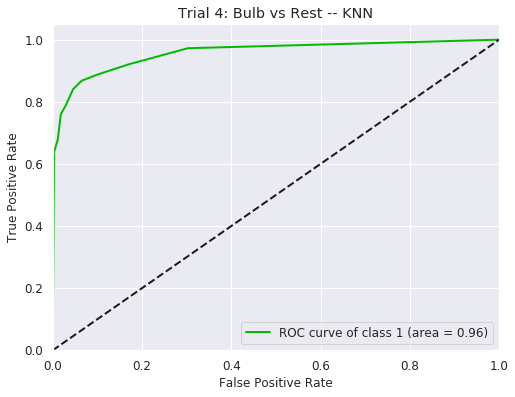

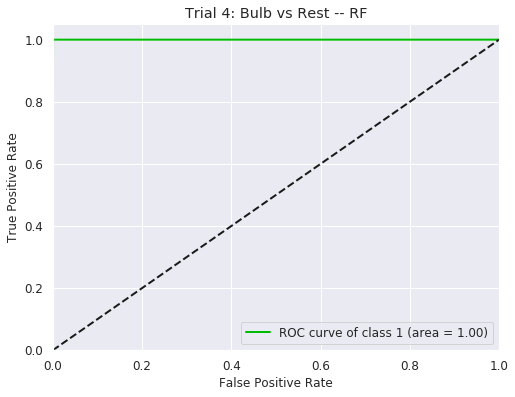

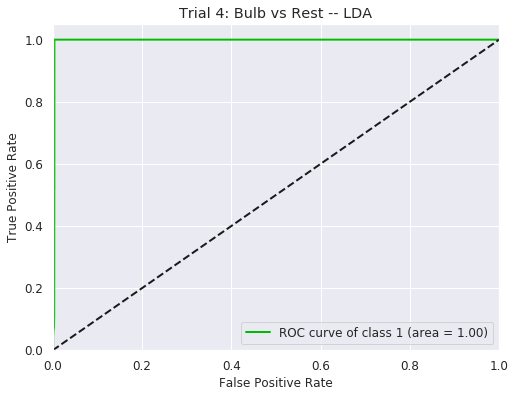

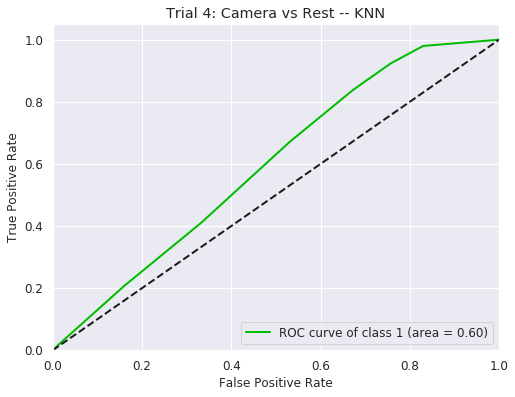

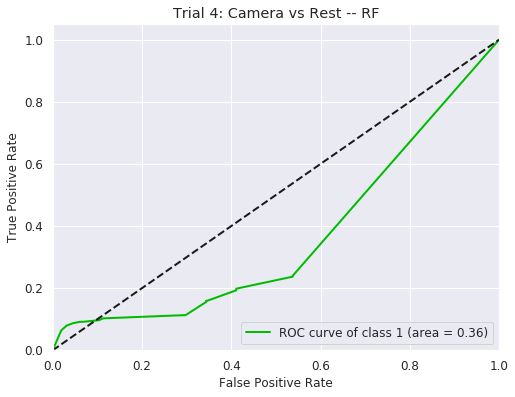

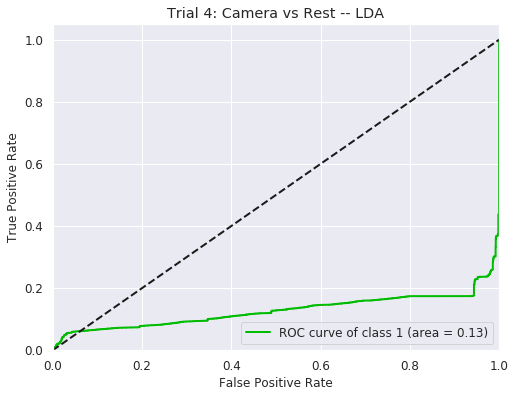

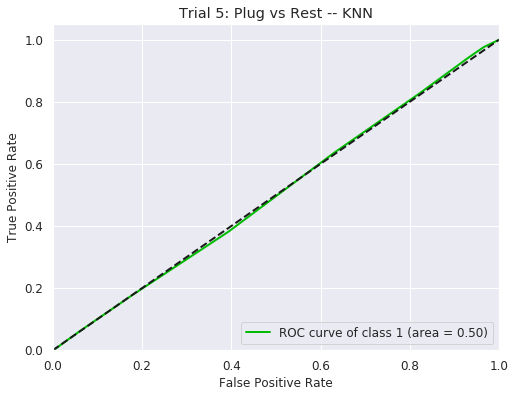

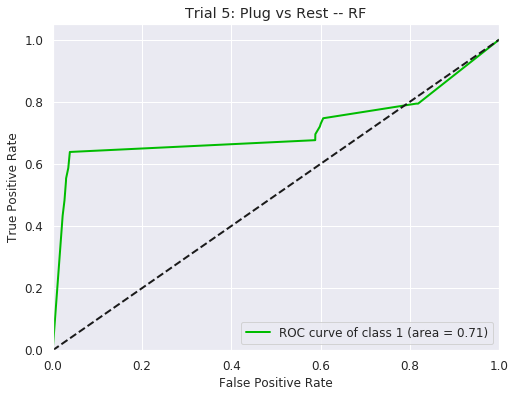

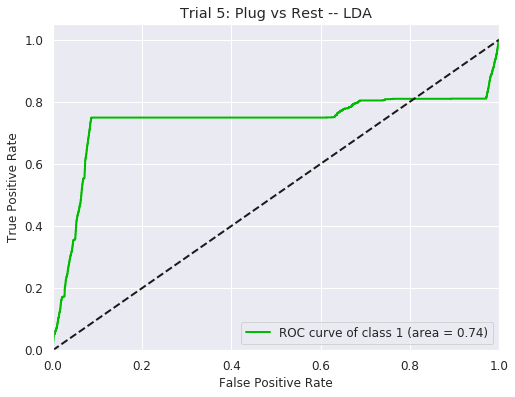

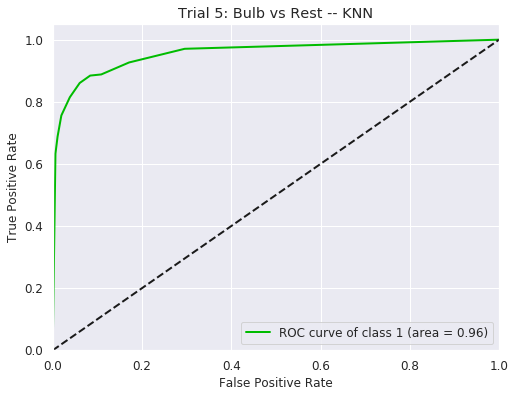

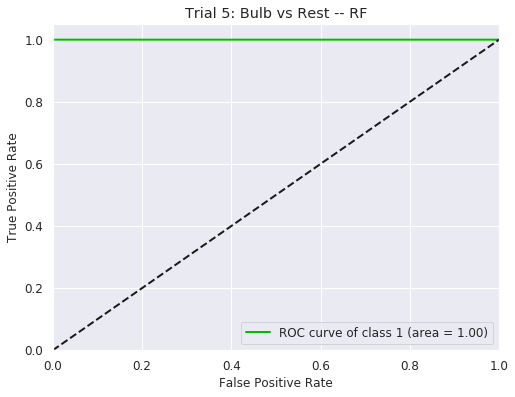

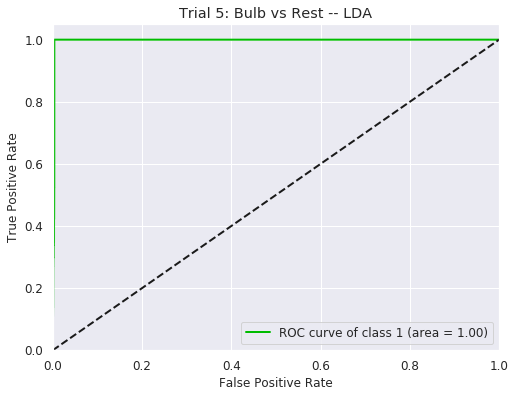

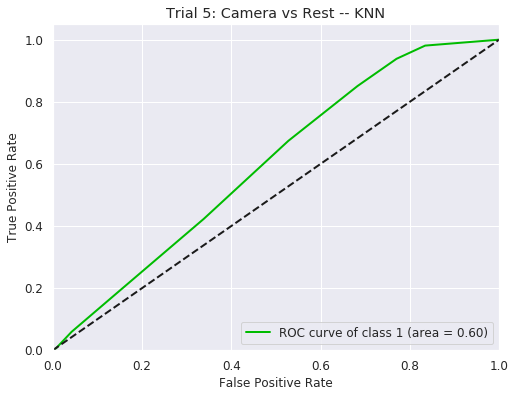

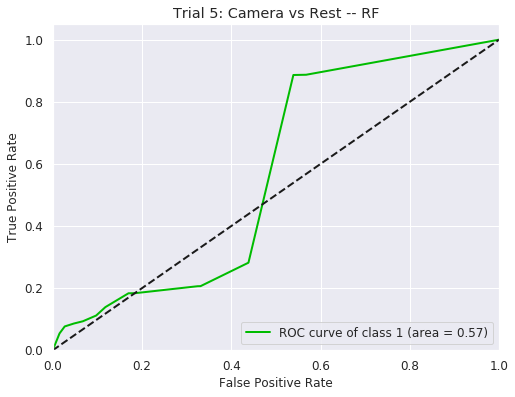

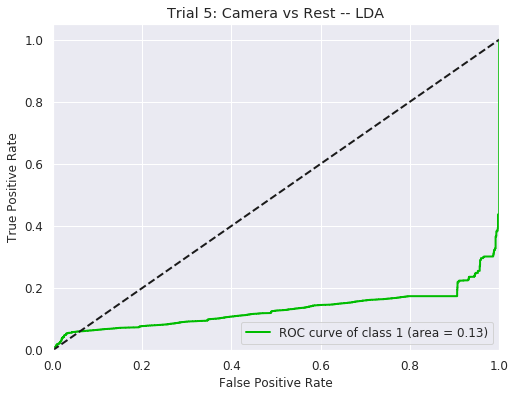

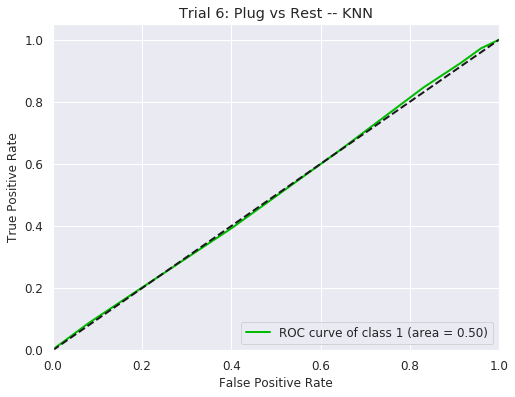

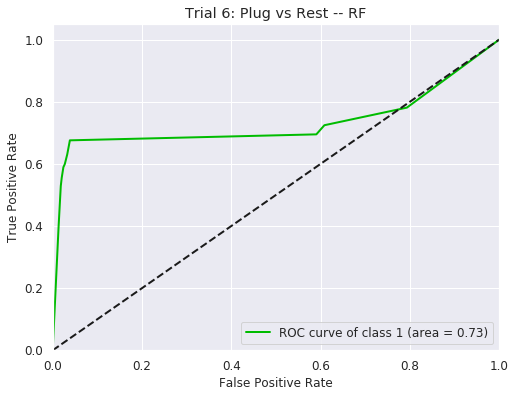

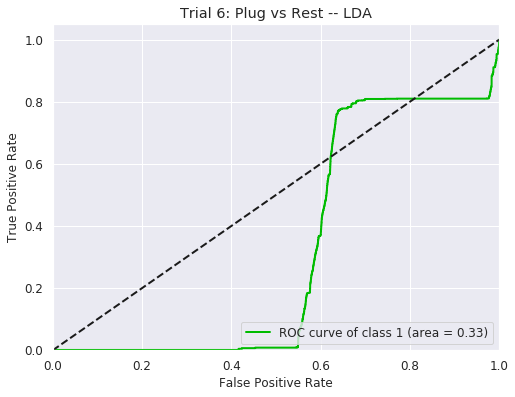

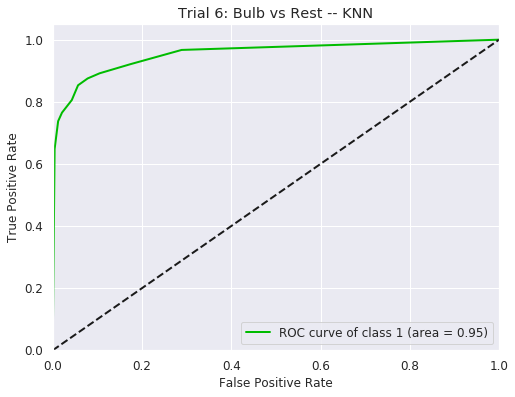

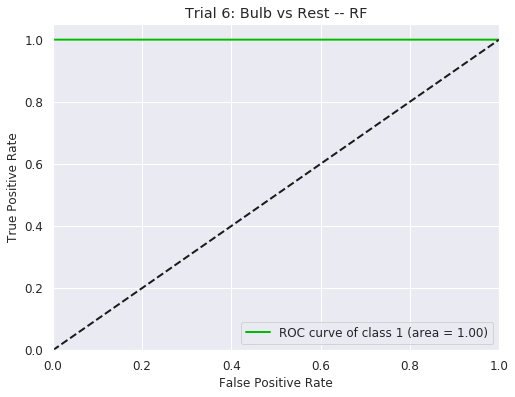

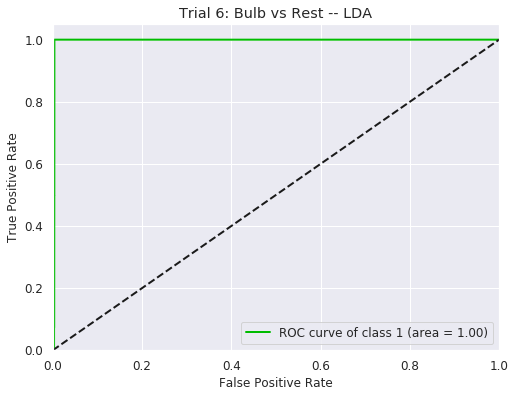

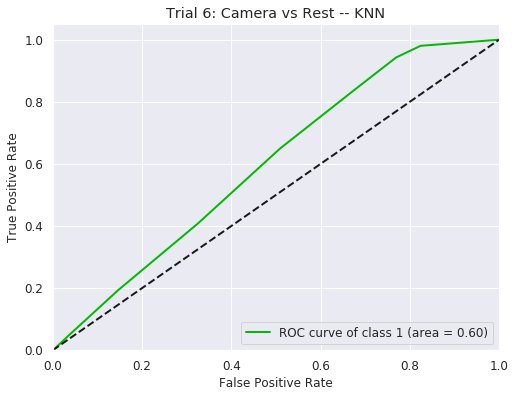

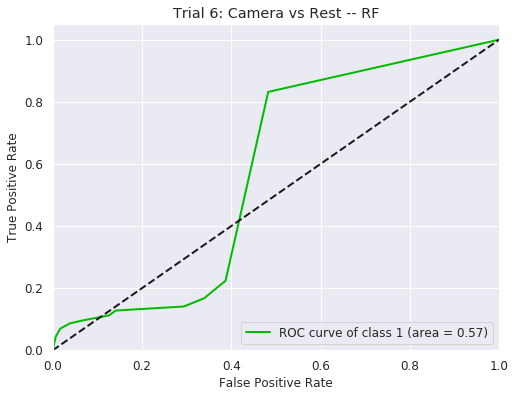

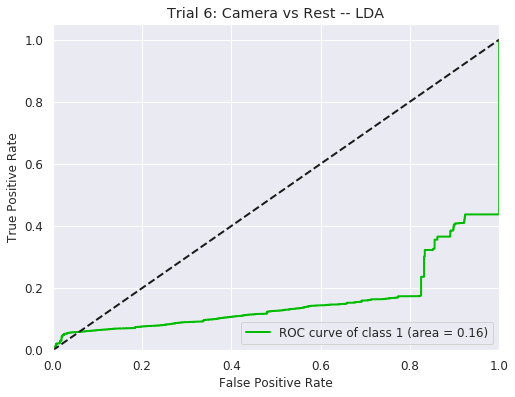

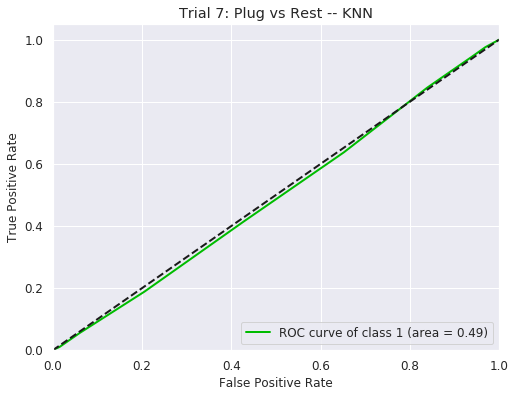

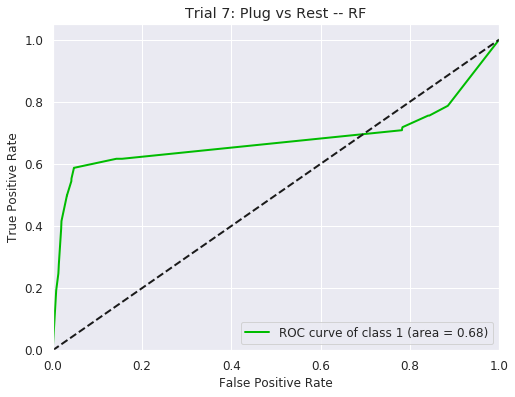

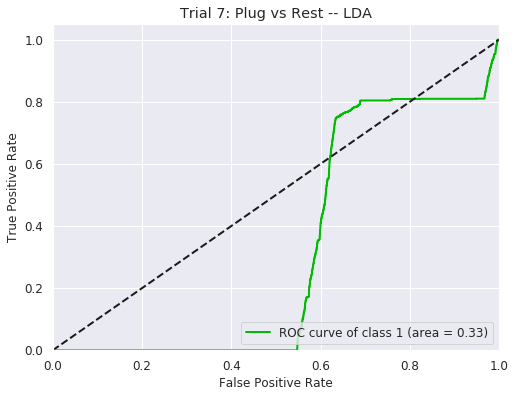

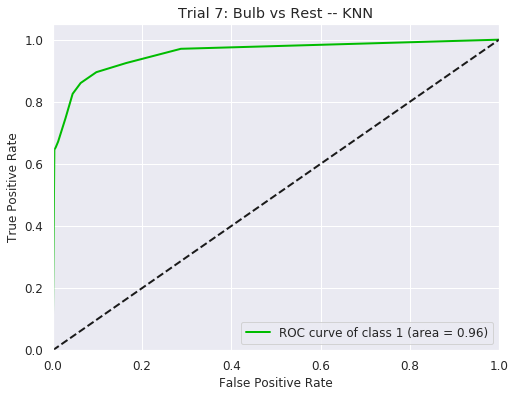

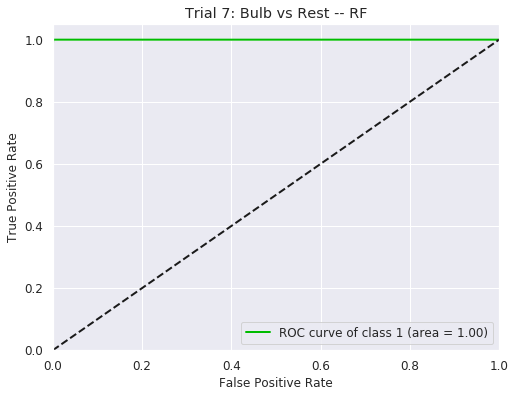

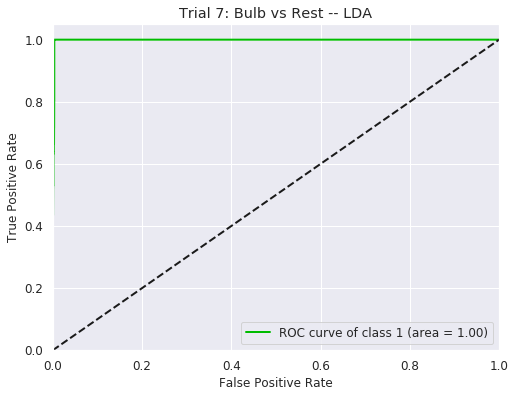

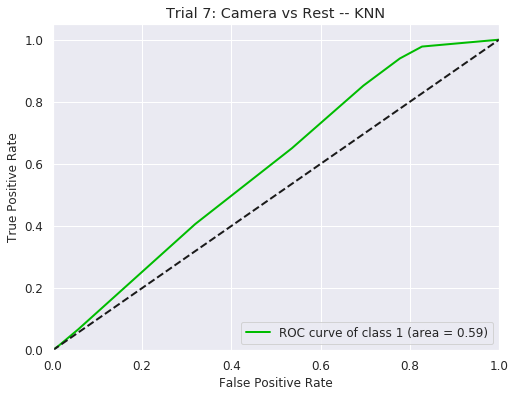

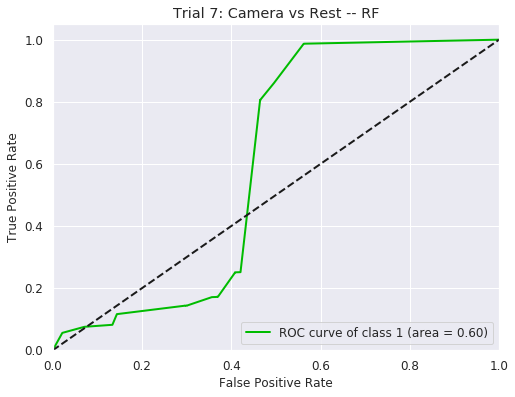

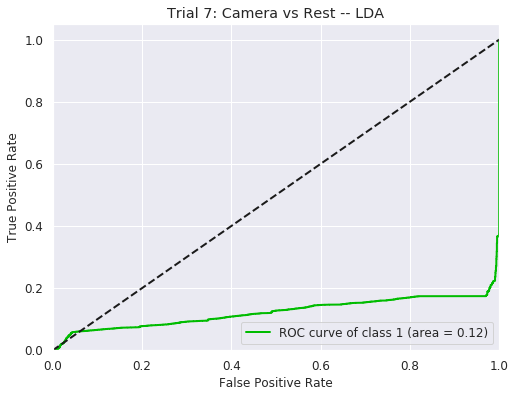

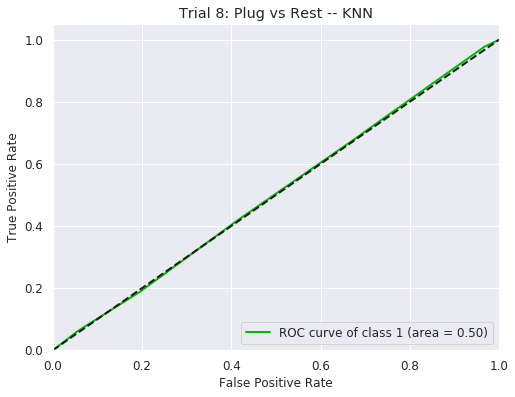

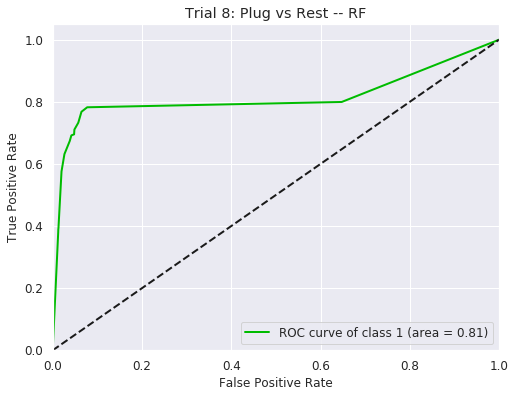

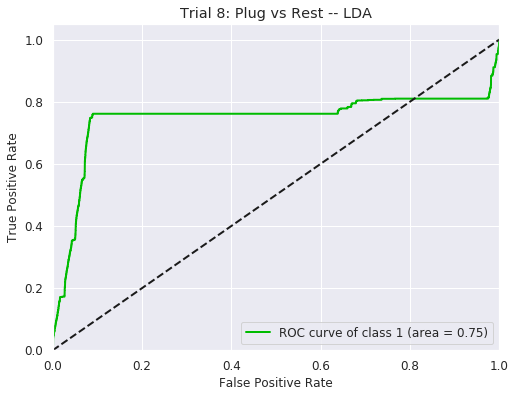

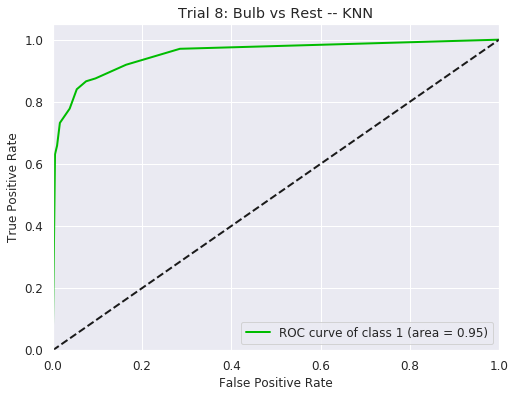

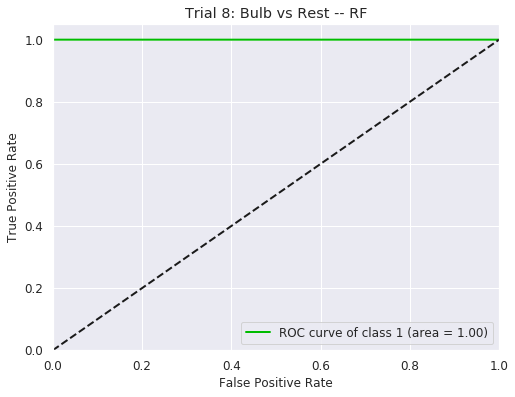

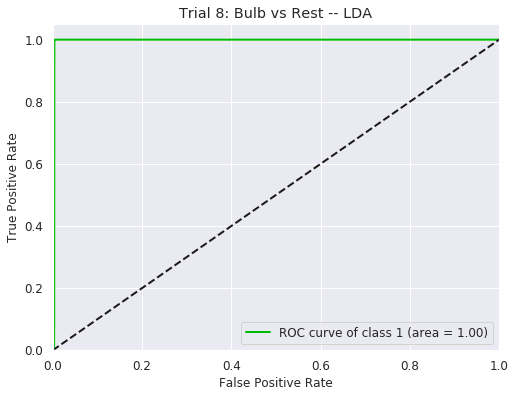

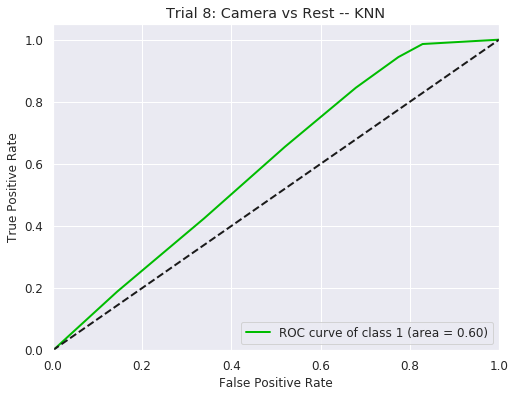

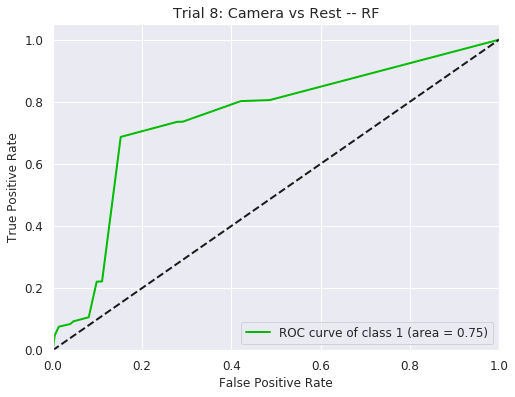

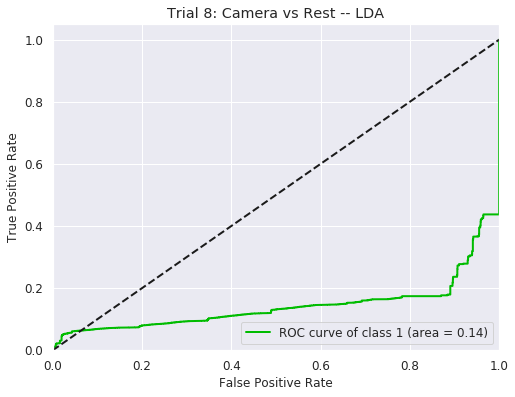

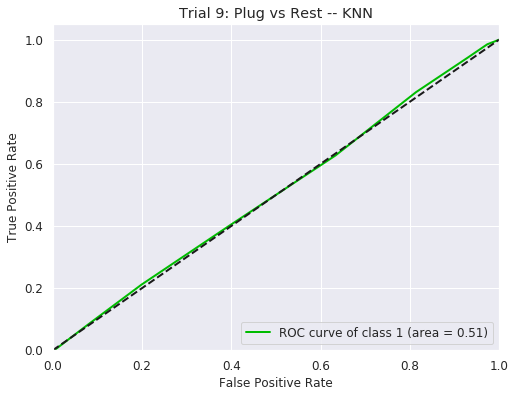

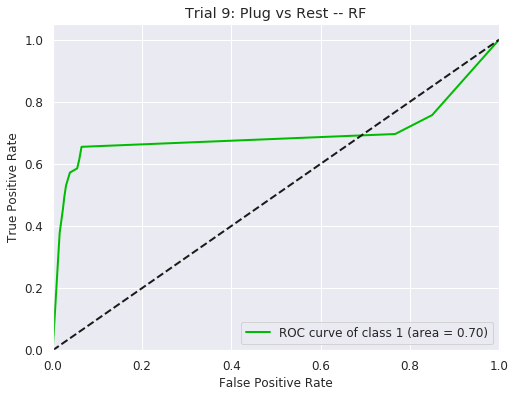

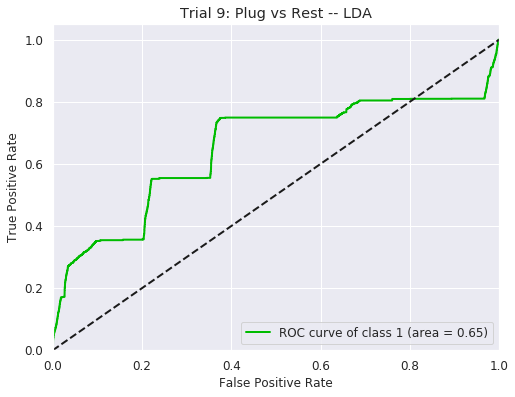

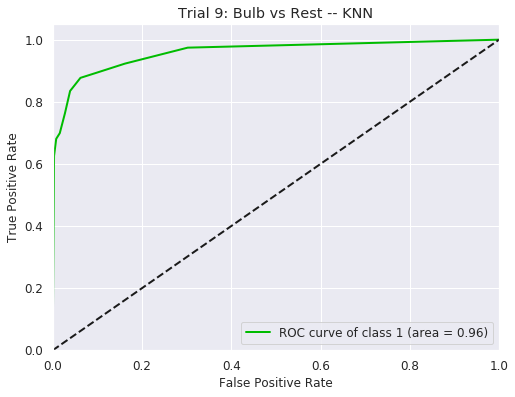

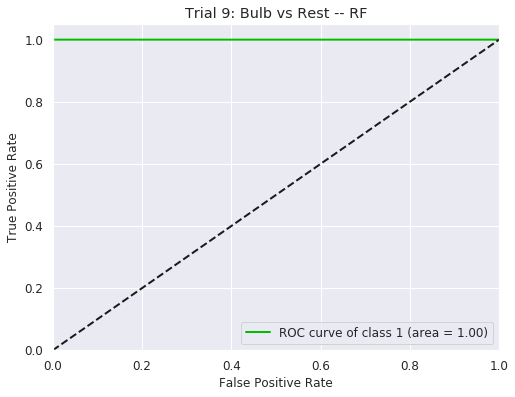

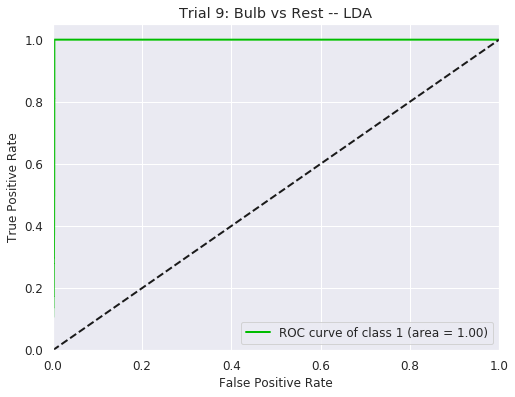

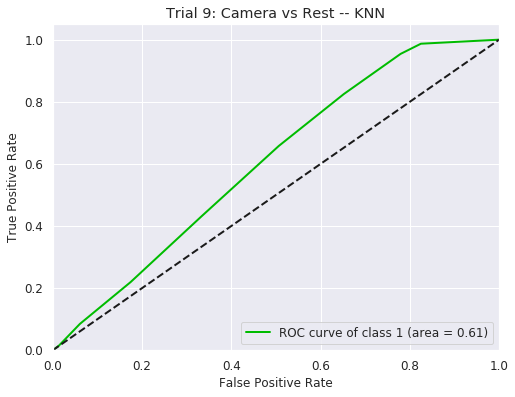

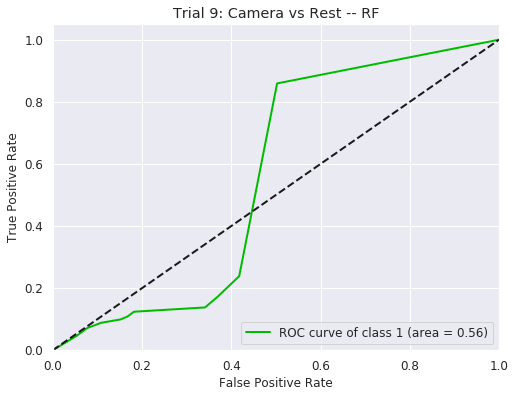

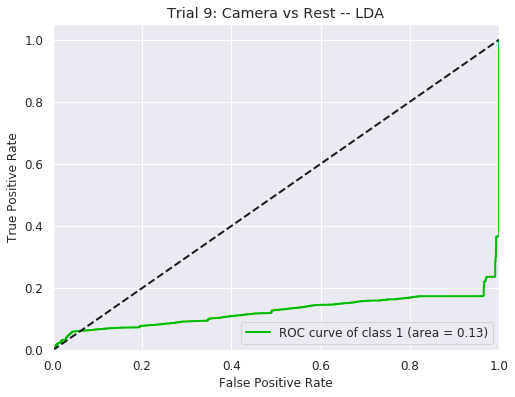

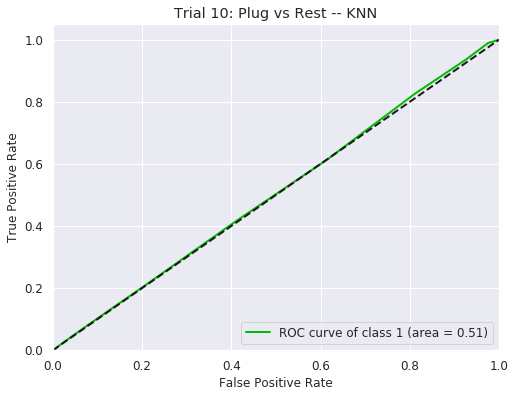

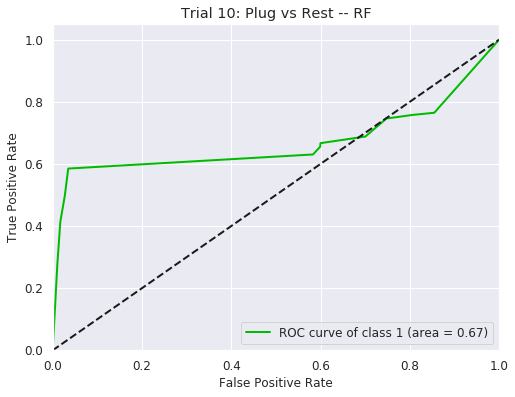

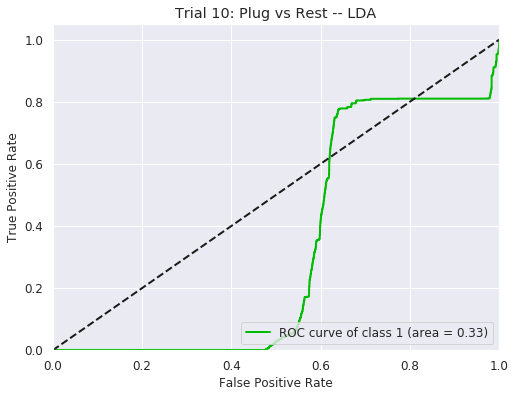

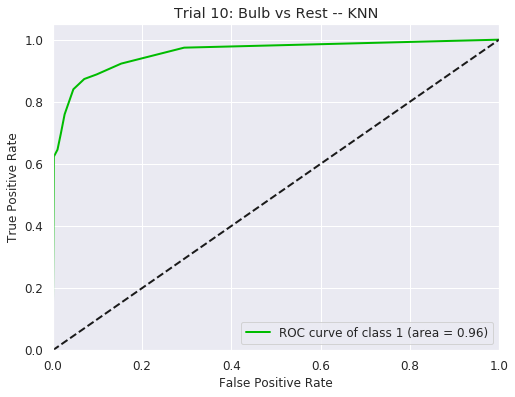

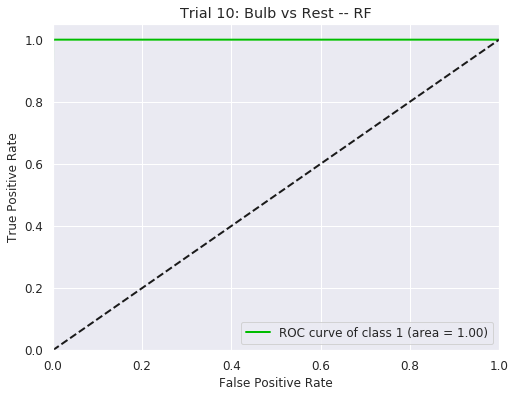

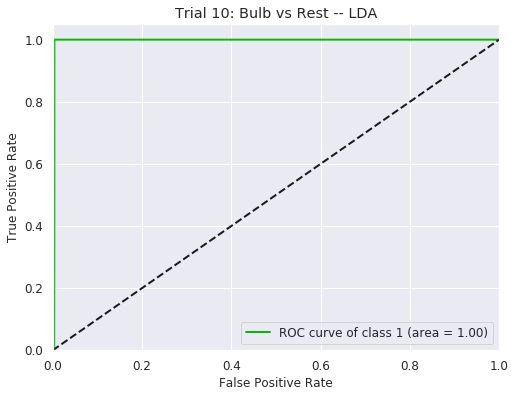

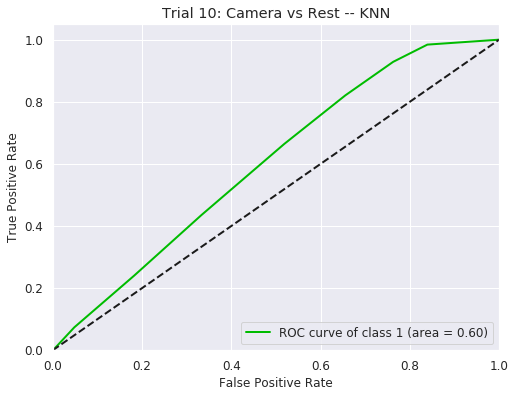

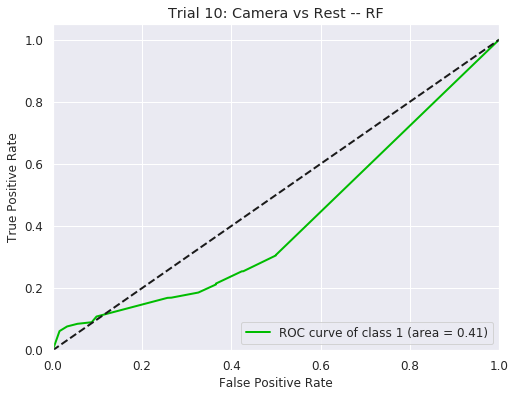

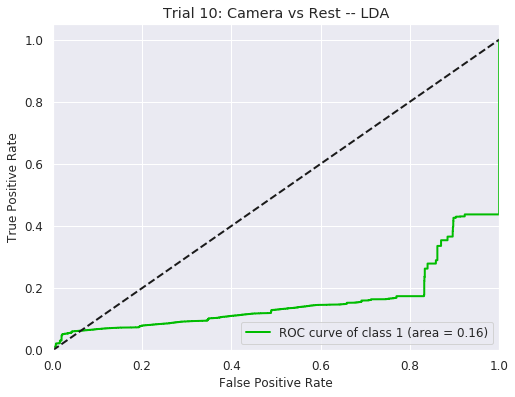

In [42]:
# Plotting ROC curves
sns.set(font_scale=1)

for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()

    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Time Performance

In [43]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in device_types:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 1.67123603821 seconds
(Bulb, KNN) : 0.240396022797 seconds
(Bulb, RF) : 0.0680720806122 seconds
(Bulb, LDA) : 0.00928711891174 seconds
(Camera, KNN) : 0.259763002396 seconds
(Camera, RF) : 0.083221912384 seconds
(Camera, LDA) : 0.0340368747711 seconds
(Plug, KNN) : 0.249789953232 seconds
(Plug, RF) : 0.0739920139313 seconds
(Plug, LDA) : 0.00981688499451 seconds

Trial  1
Total time: 1.61607813835 seconds
(Bulb, KNN) : 0.24050784111 seconds
(Bulb, RF) : 0.0679538249969 seconds
(Bulb, LDA) : 0.00956010818481 seconds
(Camera, KNN) : 0.258806943893 seconds
(Camera, RF) : 0.0761699676514 seconds
(Camera, LDA) : 0.00918102264404 seconds
(Plug, KNN) : 0.244956016541 seconds
(Plug, RF) : 0.0714159011841 seconds
(Plug, LDA) : 0.00953102111816 seconds

Trial  2
Total time: 1.62067103386 seconds
(Bulb, KNN) : 0.248062849045 seconds
(Bulb, RF) : 0.0703990459442 seconds
(Bulb, LDA) : 0.00927686691284 seconds
(Camera, KNN) : 0.258511066437 seconds
(Camera, RF) : 0.0759620666504

### Feature Importance

In [44]:
# Extract feature importance values
df_featImp = pd.DataFrame()
for i,f in enumerate(w.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [45]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [46]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
display(feat_imp)
feat_imp.to_csv('Results/wifi-feature_importance.csv', mode='w')

,Mean,StdDev,CI_MOE
PacketLength,0.211326,0.158590,0.100301
Belkin,0.195742,0.197111,0.124664
Dropcam,0.194121,0.224140,0.141758
Assoc_Packets,0.132812,0.089722,0.056745
QoS_Null,0.119303,0.095171,0.060192
Lifi,0.069966,0.081231,0.051375
QoS_Data,0.031134,0.035971,0.022750
Time,0.028417,0.018151,0.011480
Data,0.011903,0.011624,0.007352
Tp-link,0.005277,0.009598,0.006070


### Sampling Counts

In [47]:
print "Packet Counts Prior to Resampling"
print df["DeviceType"].value_counts()

Packet Counts Prior to Resampling
plug      85512
camera    71399
bulb       1231
Name: DeviceType, dtype: int64


Training Set plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

Test Set camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


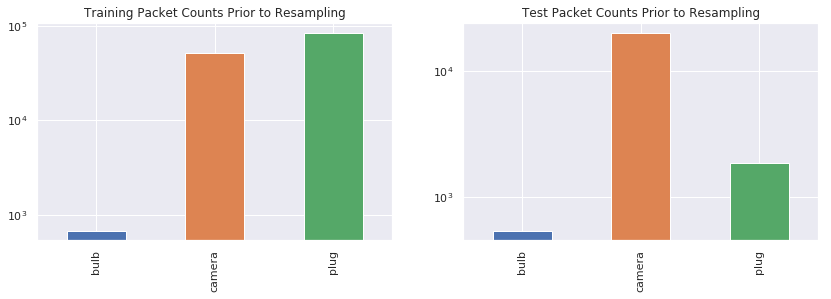

In [48]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling", logy=True);
print "Training Set", df_train["DeviceType"].value_counts()
print

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling", logy=True);
print "Test Set", df_test["DeviceType"].value_counts()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


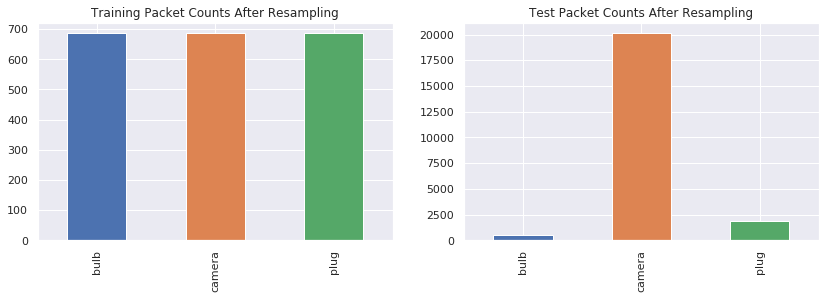

In [49]:
# Plot post-sampling
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
